<a href="https://colab.research.google.com/github/tirthpatel1111/Tops/blob/main/Nueral%20network%20and%20deep%20learning/project/emotion_detaction_tops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle # creating .kaggle folder to store kaggle file
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.74GB/s]


In [ ]:
!unzip /content/fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr
import tensorflow as tf
from PIL import Image


from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras import layers, models, regularizers, optimizers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

/tmp/ipython-input-549354337.py:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
project_name = 'FER_2013_Emotion_Detection'

models = [
    'Custom_CNN_from Scratch',
    'Custom_CNN_from_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50V2_Transfer_Learning'
]

In [ ]:
base_dir = '/content/'

proj_dir = os.path.join(base_dir,project_name)
os.makedirs(proj_dir,exist_ok=True)

In [ ]:
for i in models:
  model_dir = os.path.join(proj_dir,i)
  os.makedirs(model_dir,exist_ok=True)

In [ ]:
image_exits=['jpeg','jpg','png']

In [ ]:
data_dir='/content/train'

for root,dir,files in os.walk(data_dir):
  for file in files:
    file_path=os.path.join(root,file)
    try:
      file_type=imghdr.what(file_path)
      if file_type not in image_exits:
        print(f"Image not in ext list {file_path}")
        os.remove(file_path)
    except:
       print(f"Issue with image {file_path}, Error: {e}")
       os.remove(file_path)

In [ ]:
def count_files_from_dir(diractory,name):
  count={}
  for i in os.listdir(diractory):
    item_path=os.path.join(diractory,i)
    if os.path.isdir(item_path):
      count[i]=len(os.listdir(item_path))
  df=pd.DataFrame(count,index=[name])
  return df

In [ ]:
train="/content/train"
test="/content/test"


In [ ]:
train_ds_count=count_files_from_dir(train,"train")

In [ ]:
def plot_img_from_generator(generetor,num_img=4):
  image,labels=next(generetor)
  fig,ax=plt.subplots(nrows=1,ncols=num_img,figsize=(15,15))
  for img,lab,ax in zip(image,labels,ax):
    ax.imshow(img)
    class_label = dict((v,k) for k,v in generator.class_indices.items())
    ax.set_title(class_label[int(label)])
    ax.axis('off')

In [ ]:
test_ds_count=count_files_from_dir(test,"test")

In [ ]:
def plot_img_dir(dir_path,class_name,num_img=6):
  path_calss=os.path.join(dir_path,class_name)
  img=os.listdir(path_calss)
  if num_img>len(img):
    num_img=len(img)
  selectd_img=random.sample(img,num_img)
  fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(5,5))
  ax=ax.ravel()
  for i,img_file in enumerate(selectd_img):
    img=load_img(os.path.join(path_calss,img_file))
    ax[i].imshow(img)
    ax[i].set_title(class_name)
    ax[i].axis('off')


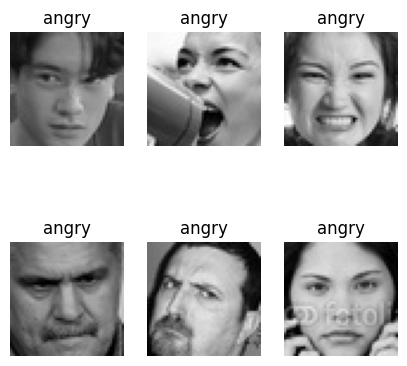

In [ ]:
plot_img_dir(train,"angry")

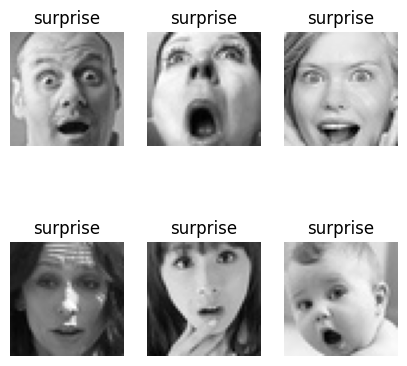

In [ ]:
plot_img_dir(test,"surprise")

In [ ]:
train_data_dir='/content/train'
test_data_dir='/content/test'

In [ ]:
img_width,img_height=48,48
batch_size=64
epochs=50
num_class=7

In [ ]:
data_genrator=ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_genrator=data_genrator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')
validation_gerator=data_genrator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')
test_genrator=data_genrator.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

#

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_label=train_genrator.class_indices
print(train_class_label)
validation_class_label=validation_gerator.class_indices
print(train_class_label)
test_class_label=test_genrator.class_indices
print(train_class_label)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(img_width,img_height,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))

#ann
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_class,activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,644,167 (6.27 MB)

 Trainable params: 1,643,271 (6.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:

cnn_path = '/content/FER_2013_Emotion_Dection/Custom_CNN_from_Scratch'
name = 'Custom_CNN_From_Scratch.keras'
chk_path = os.path.join(cnn_path,name)
chk_path

'/content/FER_2013_Emotion_Dection/Custom_CNN_from_Scratch/Custom_CNN_From_Scratch.keras'

In [ ]:
checkpoint = ModelCheckpoint(filepath=chk_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=7,
                           verbose=1,
                           restore_best_weights=True)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=7,
                              verbose=1,
                              min_delta=0.0001)

In [ ]:
csv_logger = CSVLogger(os.path.join(cnn_path, 'training_log.csv'))

In [ ]:
Callbacks = [checkpoint,early_stop,reduce_lr]

In [ ]:
train_genrator.samples

22968

In [ ]:
import math

train_steps_per_epoch = math.ceil(train_genrator.samples / train_genrator.batch_size)

validation_steps_per_epoch = math.ceil(len(validation_gerator) / validation_gerator.batch_size)

test_steps_per_epoch = math.ceil(test_genrator.samples / test_genrator.batch_size)

In [ ]:
history = model.fit(
    train_genrator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 50,
    validation_data = validation_gerator,
    validation_steps = validation_steps_per_epoch,
    callbacks = Callbacks
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/359 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1915 - loss: 2.4435
Epoch 1: val_loss improved from inf to 2.23242, saving model to /content/FER_2013_Emotion_Dection/Custom_CNN_from_Scratch/Custom_CNN_From_Scratch.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.1916 - loss: 2.4403 - val_accuracy: 0.2812 - val_loss: 2.2324 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2362 - loss: 1.8589
Epoch 2: val_loss improved from 2.23242 to 1.77616, saving model to /content/FER_2013_Emotion_Dection/Custom_CNN_from_Scratch/Custom_CNN_From_Scratch.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.2362 - loss: 1.8589 - val_accuracy: 0.2969 - val_loss: 1.7762 - learning_rate: 0.0010
Epoch 3/50
357/359 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2432 - loss: 1.8252
Epoch 3: val_loss did not improve from 1.77616
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.2432 - loss: 1.8251 - val_accuracy: 0.2422 - val_los

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

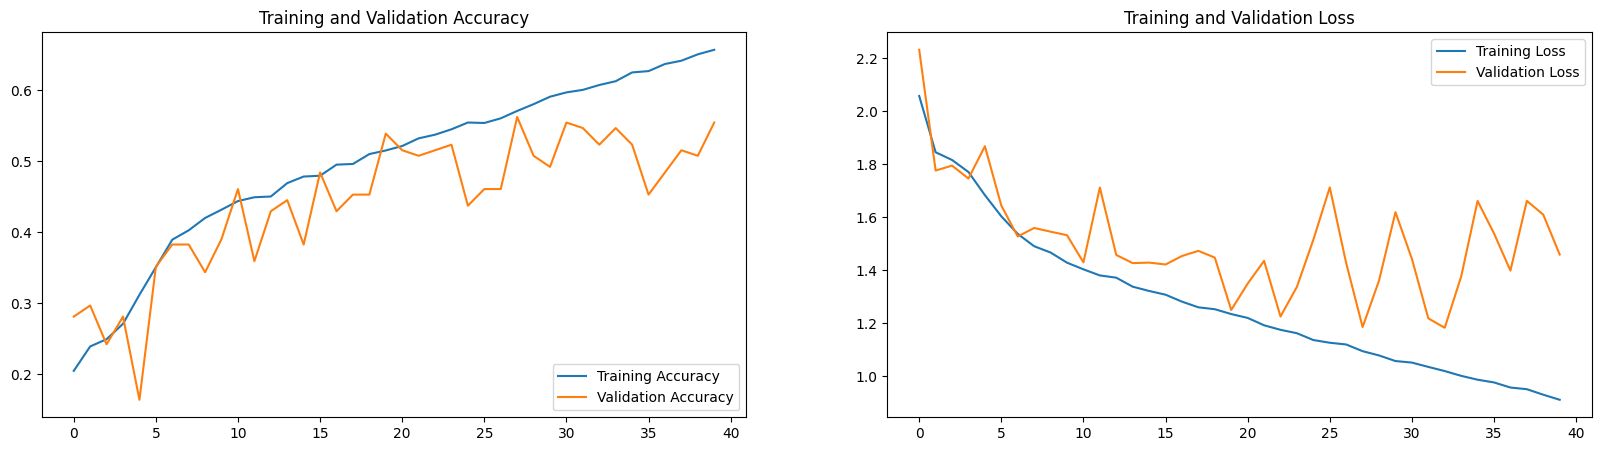

In [ ]:
plot_training_history(history)

In [ ]:
pred=model.predict(test_genrator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


In [ ]:
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Get the predicted class index for each sample
predicted_classes = np.argmax(pred, axis=1)

In [ ]:
predicted_classes

array([5, 6, 3, ..., 0, 3, 5])

In [ ]:
test_genrator.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

## Model 2 :Image Augmenmtation

In [ ]:
train_data_dir='/content/train'
test_data_dir='/content/test'

In [ ]:
img_width,img_height=48,48
batch_size=64
epoch=10
num_classes=7

In [ ]:
data_generator=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
    )

In [ ]:
train_ds = data_genrator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.


In [ ]:
data_genrator=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [ ]:
validation_gerator=data_genrator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    subset='validation')
test_genrator=data_genrator.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,

    color_mode='grayscale')


Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_label=train_genrator.class_indices
print(train_class_label)
validation_class_label=validation_gerator.class_indices
print(train_class_label)
test_class_label=test_genrator.class_indices
print(train_class_label)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(img_width,img_height,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))

#ann
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_class,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,644,167 (6.27 MB)

 Trainable params: 1,643,271 (6.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
cnn_path = '/content/FER_2013_Emotion_Dection/Custom_CNN_from_Augmentation'
name = 'Custom_CNN_From_Scratch.keras'
chk_path = os.path.join(cnn_path,name)
chk_path

'/content/FER_2013_Emotion_Dection/Custom_CNN_from_Augmentation/Custom_CNN_From_Scratch.keras'

In [ ]:
checkpoint = ModelCheckpoint(filepath=chk_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=7,
                           verbose=1,
                           restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=7,
                              verbose=1,
                              min_delta=0.0001)

In [ ]:
csv_logger = CSVLogger(os.path.join(cnn_path, 'training_log.csv'))

In [ ]:
Callbacks = [checkpoint,early_stop,reduce_lr]

In [ ]:
import math

train_steps_per_epoch = math.ceil(train_genrator.samples / train_genrator.batch_size)

validation_steps_per_epoch = math.ceil(len(validation_gerator) / validation_gerator.batch_size)

test_steps_per_epoch = math.ceil(test_genrator.samples / test_genrator.batch_size)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_genrator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 50,
    validation_data = validation_gerator,
    validation_steps = validation_steps_per_epoch,
    callbacks = Callbacks
)

Epoch 1/50
357/359 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1847 - loss: 2.4794
Epoch 1: val_loss improved from inf to 1.91157, saving model to /content/FER_2013_Emotion_Dection/Custom_CNN_from_Augmentation/Custom_CNN_From_Scratch.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.1849 - loss: 2.4759 - val_accuracy: 0.2422 - val_loss: 1.9116 - learning_rate: 0.0010
Epoch 2/50
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2265 - loss: 1.8520
Epoch 2: val_loss improved from 1.91157 to 1.84210, saving model to /content/FER_2013_Emotion_Dection/Custom_CNN_from_Augmentation/Custom_CNN_From_Scratch.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.2266 - loss: 1.8519 - val_accuracy: 0.1953 - val_loss: 1.8421 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2401 - loss: 1.8228
Epoch 3: val_loss improved from 1.84210 to 1.79984, saving model to /content/FER_2013_Emotion_Dection/Custom_CNN_from_Augmentation/Custo

## MODEL VGGNET 16

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

In [ ]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split=0.2)


test_preprocessor = ImageDataGenerator(rescale=1./255)


train_generator = data_generator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=True)

test_generator = test_preprocessor.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
classes = np.array(train_generator.classes)

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes = np.unique(classes),
    y = classes
)

In [ ]:
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
classes = 7
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(48,48, 3))
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Flatten()(vgg.output)

model= Dense(1024,activation='relu')(model)
model = Dropout(0.5)(model)

model = Dense(512,activation='relu')(model)
model = Dropout(0.5)(model)


output = Dense(7,activation='softmax')(model)


model = Model(inputs= vgg.input, outputs=output)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7)              │         3,59

 Total params: 15,768,391 (60.15 MB)

 Trainable params: 15,768,391 (60.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')


earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training_log.keras'))

In [ ]:
callbacks = [checkpoint,earlystop,reduce_lr]

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = len(validation_generator) // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
h = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = validation_steps_epoch,
    callbacks = callbacks,
    class_weight = class_weight_dict
)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1574 - loss: 1.9424
Epoch 1: val_loss did not improve from 1.94329
359/359 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.1573 - loss: 1.9424 - val_accuracy: 0.1328 - val_loss: 1.9463 - learning_rate: 0.0010
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1284 - loss: 1.9422
Epoch 2: val_loss did not improve from 1.94329
359/359 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.1285 - loss: 1.9422 - val_accuracy: 0.2266 - val_loss: 1.9461 - learning_rate: 0.0010
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.0923 - loss: 1.9617
Epoch 3: val_loss did not improve from 1.94329
359/359 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.0923 - loss: 1.9616 - val_accuracy: 0.1172 - val_loss: 1.9472 - learning_rate: 0.0010
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1180 - loss: 1.9458
Epoch 4: val_loss did not improve from 1.94329
359/359 ━━━━━━━━━━━━━━━━━━━━

## RESNET -50

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

In [ ]:
batch_size = 64

In [ ]:

train_datagen = ImageDataGenerator(
  rescale=1 / 255.,
  rotation_range=10,
  zoom_range=0.2,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True,
  fill_mode='nearest'
  )


test_datagen = ImageDataGenerator(
rescale=1 / 255.0
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
 train_dir,
 class_mode="categorical",
 target_size=(224, 224),
 color_mode='rgb',
 shuffle=True,
 batch_size=batch_size,
 subset='training'
)

test_generator = test_datagen.flow_from_directory(
 test_dir,
 class_mode="categorical",
 target_size=(224, 224),
 color_mode="rgb",
 shuffle=False,
 batch_size=batch_size
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
classes = np.array(train_generator.classes)

In [ ]:
class_weights = compute_class_weight(
class_weight='balanced',
classes=np.unique(classes),
y=classes  )

In [ ]:
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
class_weights_dict

{0: np.float64(1.0266046844269623),
 1: np.float64(9.406618610747051),
 2: np.float64(1.0010460615781582),
 3: np.float64(0.5684387684387684),
 4: np.float64(0.8260394187886635),
 5: np.float64(0.8491274770777877),
 6: np.float64(1.293372978330405)}

In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),include_top=False,weights='imagenet')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
ResNet50V2.trainable = True

for i in ResNet50V2.layers[:-50]:
  i.trainable = False

In [ ]:
model = Sequential([
    ResNet50V2,
    Dropout(0.25),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')

])

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                             min_lr=0.00005,
                              verbose=1)


In [ ]:
callbacks = [checkpoint, earlystop]

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1

test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
h = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 20,
    validation_data = test_generator,
    validation_steps = test_steps_epoch,
    callbacks = callbacks,
    class_weight=class_weights_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.3162 - loss: 2.0354
Epoch 1: val_loss improved from inf to 1.29866, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 438s 900ms/step - accuracy: 0.3163 - loss: 2.0350 - val_accuracy: 0.5081 - val_loss: 1.2987
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.4527 - loss: 1.6007
Epoch 2: val_loss did not improve from 1.29866
449/449 ━━━━━━━━━━━━━━━━━━━━ 379s 844ms/step - accuracy: 0.4527 - loss: 1.6005 - val_accuracy: 0.5013 - val_loss: 1.4370
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.5113 - loss: 1.3655
Epoch 3: val_loss improved from 1.29866 to 1.20521, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 383s 853ms/step - accuracy: 0.5114 - loss: 1.3654 - val_accuracy: 0.5582 - val_loss: 1.2052
Ep